In [107]:
#Import needed packages

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns


In [108]:
#Load the dataset

Dataset = pd.read_csv('Data/superstore_data.csv')
print(Dataset.shape)
Dataset.head()
#make new dummy columns for the education and martial status value 
Dataset_dummy = pd.get_dummies(Dataset[['Marital_Status','Education']])

Dataset = pd.concat([Dataset,Dataset_dummy],axis=1)

Income_missing = Dataset[Dataset['Income'].isna()]
Rm_data = Dataset.dropna()
print(Rm_data.shape)
print(Income_missing.shape)

Income_missing.head()


(2240, 22)
(2216, 35)
(24, 35)


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
134,8996,1957,PhD,Married,NaN,2,1,11/19/2012,4,230,...,True,False,False,False,False,False,False,False,False,True
262,1994,1983,Graduation,Married,NaN,1,0,11/15/2013,11,5,...,True,False,False,False,False,False,False,True,False,False
394,3769,1972,PhD,Together,NaN,1,0,2/3/2014,17,25,...,False,False,True,False,False,False,False,False,False,True
449,5255,1986,Graduation,Single,NaN,1,0,2/20/2013,19,5,...,False,True,False,False,False,False,False,True,False,False
525,8268,1961,PhD,Married,NaN,0,1,11/7/2013,23,352,...,True,False,False,False,False,False,False,False,False,True


In [109]:
#Part 1) Train a method to impute the data from the column, train a random forest regressor for the income informaiton

impute_targ = Rm_data['Income']
impute_input = Rm_data.drop(columns=['Income','Dt_Customer','Marital_Status','Education'])

RandForest = sk.ensemble.RandomForestRegressor(n_estimators=200,random_state=1)

forest = RandForest.fit(impute_input,impute_targ)


#Impute the values for the missing cells and put it back into the dataset

impute_x = Income_missing.drop(columns=['Income','Dt_Customer','Marital_Status','Education'])
imputed_income = forest.predict(impute_x)

#put this into the dataset

Dataset['Income'] = Dataset['Income'].fillna(pd.Series(imputed_income))

Dataset.to_csv('Data/Imputed_Income.csv')

#See the new dataset
Dataset.head()


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,False,False,False,False,False,False,False,True,False,False
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,False,True,False,False,False,False,False,True,False,False
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,True,False,False,False,False,False,False,True,False,False
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,False,False,True,False,False,False,False,True,False,False
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,False,True,False,False,False,False,False,True,False,False


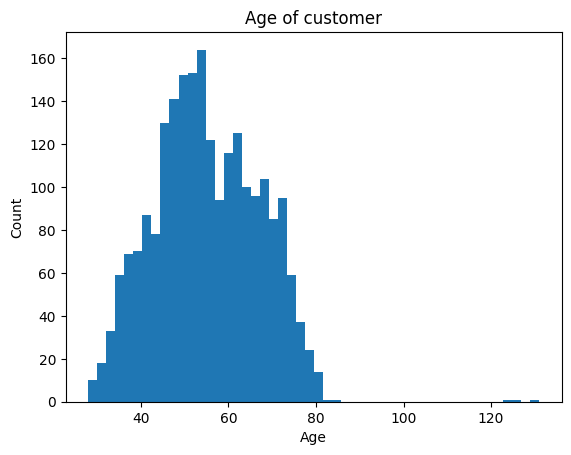

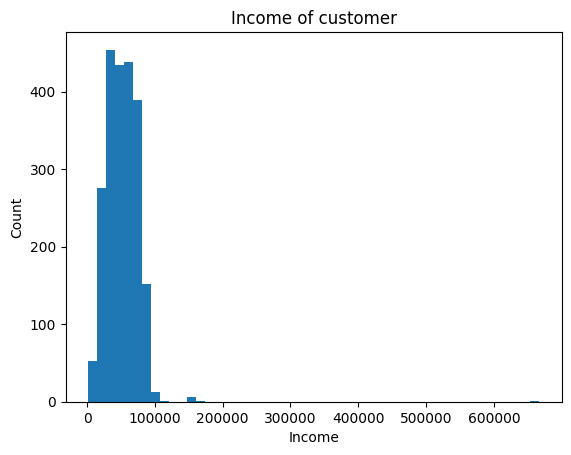

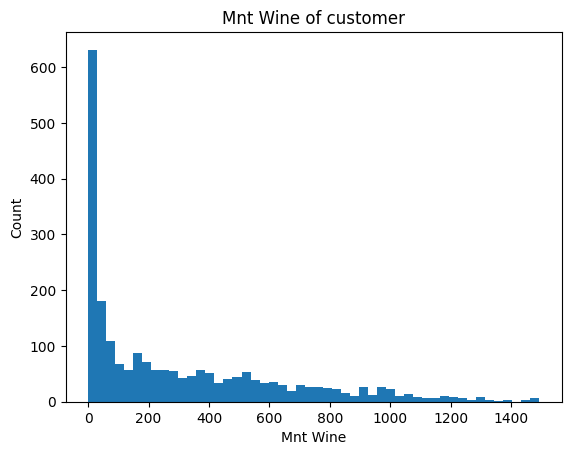

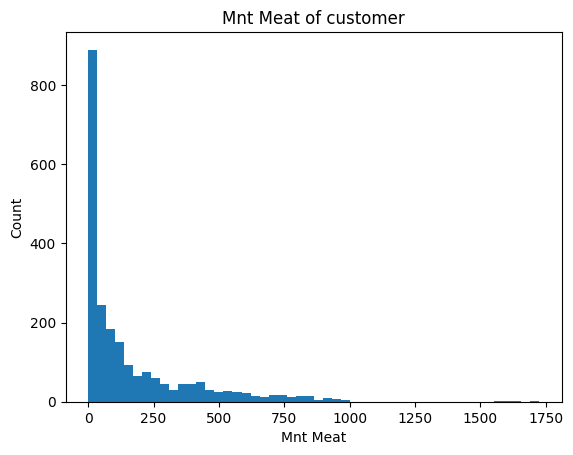

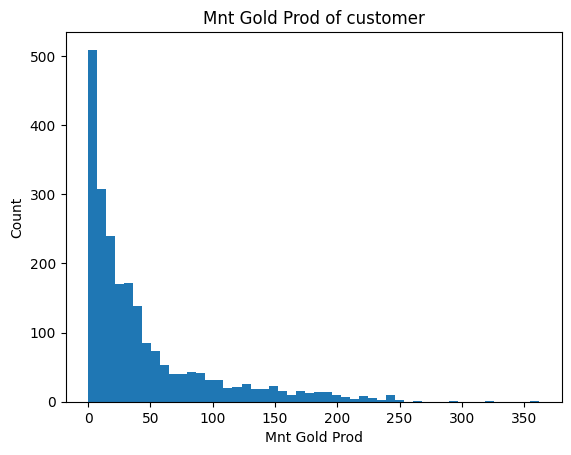

In [110]:
#Part 2) Explore the distributions

#Make histrograms of the data, display mean etc

def plot_histogram(data, bins=10, xlabel='Value', ylabel='Frequency', title='Histogram',savename='basename.png'):
    plt.figure()
    plt.hist(data, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('Figures/'+savename,dpi=200)

#Age
AGE = 2024-Dataset['Year_Birth']
plot_histogram(AGE,bins=50,xlabel='Age',ylabel='Count',title='Age of customer',savename='AgeHist.png')
#Income
Income = Dataset['Income']
plot_histogram(Income,bins=50,xlabel='Income',ylabel='Count',title='Income of customer',savename='Income.png')
#Wine
Wine = Dataset['MntWines']
plot_histogram(Wine,bins=50,xlabel='Mnt Wine',ylabel='Count',title='Mnt Wine of customer',savename='Wine.png')

#Meat
Meat = Dataset['MntMeatProducts']
plot_histogram(Meat,bins=50,xlabel='Mnt Meat',ylabel='Count',title='Mnt Meat of customer',savename='Meat.png')

#Gold Prods
GoldProd = Dataset['MntGoldProds']
plot_histogram(GoldProd,bins=50,xlabel='Mnt Gold Prod',ylabel='Count',title='Mnt Gold Prod of customer',savename='Gold.png')



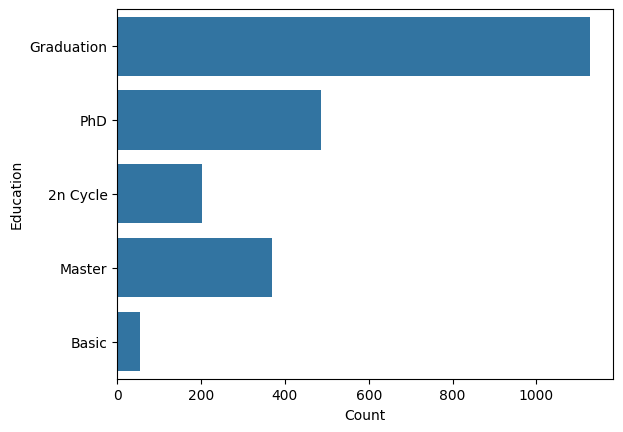

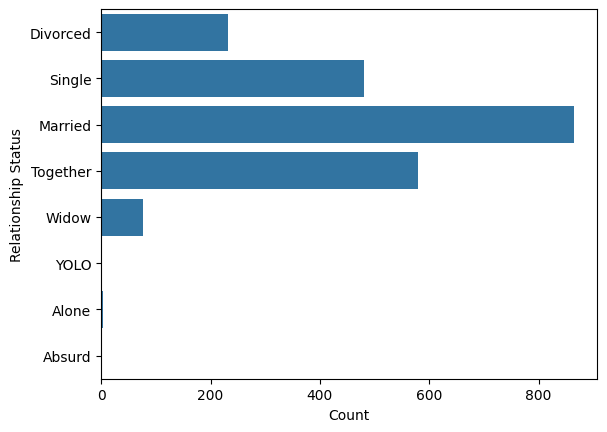

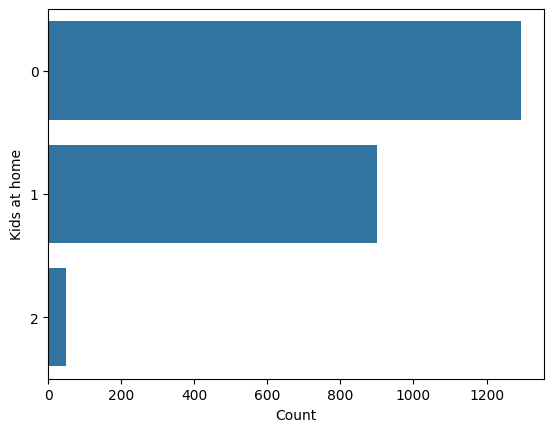

In [111]:

#Part 3 distribution of categorical variables Education, marital status

#Barplot

def plot_barplot(data, xlabel='Count', ylabel='Catergory', title='Bar Plot',savename='barbase.png'):
    plt.figure()
    sns.countplot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('Figures/'+savename,dpi=200)

#Education
Education = Dataset['Education']
Mat_Status = Dataset['Marital_Status']
TeenHome = Dataset['Teenhome'].astype('str')
plot_barplot(Education,ylabel='Education',title=None,savename='Education_bar.png')

#Marital status
plot_barplot(Dataset['Marital_Status'],ylabel='Relationship Status',title=None,savename='Marital_Status.png')

#Kids at home
plot_barplot(Dataset['Kidhome'].astype('str'),ylabel='Kids at home',title=None,savename='Kids_home.png')


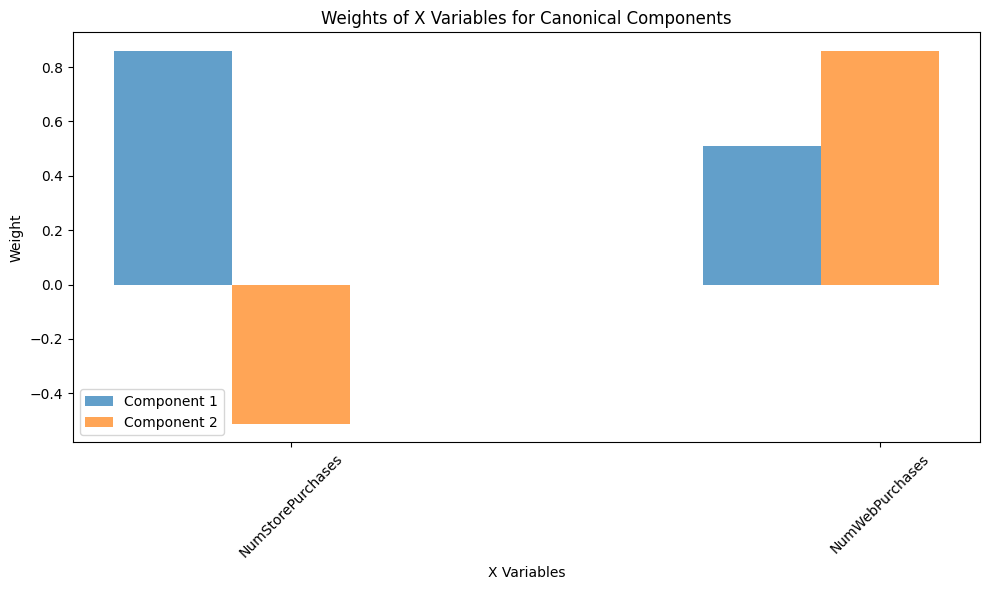

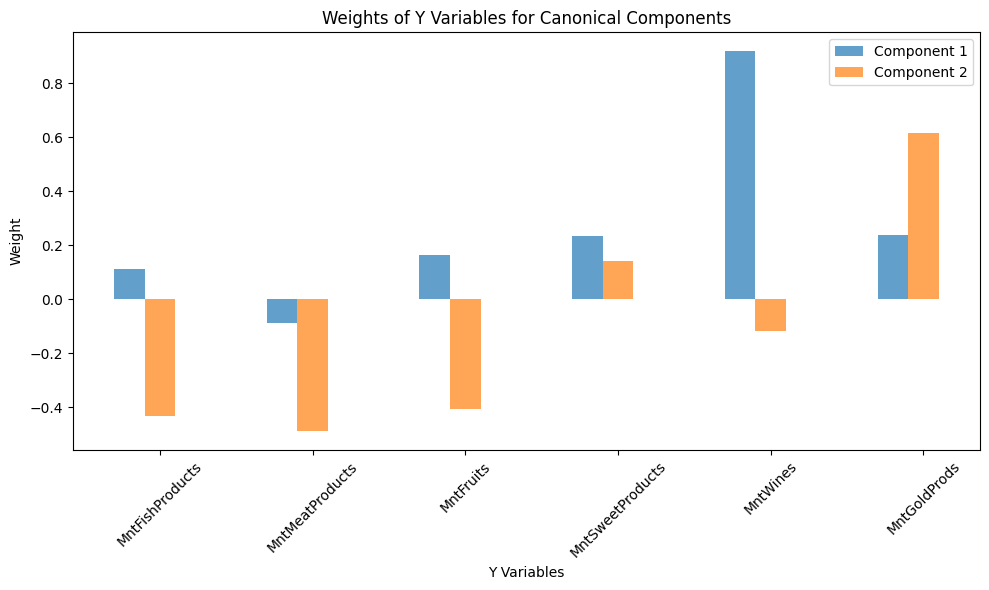

In [112]:
#Part 4) Relationship betwen number of purchases and ammount spent on different produces, do CCA

import sklearn.cross_decomposition as skcd

def cca_and_plot_weights(X_mat, Y_mat, x_labels, y_labels,num_comp=2, x_output_file='Problem2_part4_X.png', y_output_file='Problem2_part4_Y.png'):
    # Perform Canonical Correlation Analysis (CCA)
    cca = skcd.CCA(n_components=num_comp)
    cca.fit(X_mat, Y_mat)

    # Get the weights
    x_weights = cca.x_weights_
    y_weights = cca.y_weights_

    # Plot weights for X variables
    plt.figure(figsize=(10, 6))
    bar_width = 0.2

    for i in range(x_weights.shape[1]):
        plt.bar(np.arange(len(x_weights)) + (i - 1) * bar_width, x_weights[:, i], bar_width, alpha=0.7, label=f'Component {i+1}')

    plt.xlabel('X Variables')
    plt.ylabel('Weight')
    plt.title('Weights of X Variables for Canonical Components')
    plt.xticks(np.arange(len(x_weights)), x_labels, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.savefig('Figures/'+x_output_file, dpi=200)

    # Plot weights for Y variables
    plt.figure(figsize=(10, 6))

    for i in range(y_weights.shape[1]):
        plt.bar(np.arange(len(y_weights)) + (i - 1) * bar_width, y_weights[:, i], bar_width, alpha=0.7, label=f'Component {i+1}')

    plt.xlabel('Y Variables')
    plt.ylabel('Weight')
    plt.title('Weights of Y Variables for Canonical Components')
    plt.xticks(np.arange(len(y_weights)), y_labels, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.savefig('Figures/'+y_output_file, dpi=200)
    plt.show()

#Matrix for the number of purchases
Purchases = Dataset[['NumStorePurchases','NumWebPurchases']]
Mnt_spent = Dataset[['MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds']]

xlist = ['NumStorePurchases','NumWebPurchases']
ylist = ['MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds']
cca_and_plot_weights(Purchases,Mnt_spent,x_labels=xlist,y_labels=ylist,x_output_file='Purchase_X.png',y_output_file='Purchase_Y.png')



In [113]:
#Part 5 doing CCA on demographic and thier purchasing behavior

xlist = ['Year_Birth','Income','Teenhome','Kidhome']
ylist = ['MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds','NumCatalogPurchases','NumStorePurchases','NumWebPurchases']
#Matrix for the number of purchases
Demo = Dataset[xlist]
SpeningHab = Dataset[ylist]


cca_and_plot_weights(Purchases,Mnt_spent,x_labels=xlist,y_labels=ylist,num_comp=4,x_output_file='Purchase_X.png',y_output_file='Purchase_Y.png')

ValueError: `n_components` upper bound is 2. Got 4 instead. Reduce `n_components`.